The dataset used is a sample data(provided) and dataset prepared from BraTS2020 Dataset.
Kaggle Link:https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation/code

### Importing Libraries

In [2]:
pip install keras

In [3]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.7 MB/s eta 0:00:00


In [4]:
# Library for image processing and visualization
from skimage.transform import resize
from PIL import Image
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

# Library for handling file operations
import os

# Library for handling array operations
import numpy as np

# Library for handling deep learning
import tensorflow as tf
from keras.utils import plot_model
import tensorflow_addons as tfa
autotune = tf.data.AUTOTUNE

# Library for Miscellaneous tasks
import warnings

warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose
from tensorflow.keras import Model, Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tensorflow.keras.layers import Dropout
AUTOTUNE = tf.data.experimental.AUTOTUNE
import tensorflow_addons as tfa

### Data loading and preprocessing

In [6]:
# Image size
img_height = 128
img_width = 128

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Path for images in Sample dataset provided
augmented_t1 = "/content/drive/MyDrive/MRI Dataset/Tr1/TrainT1/Augmented"
augmented_t2 = "/content/drive/MyDrive/MRI Dataset/Tr2/TrainT2/Augmented"

In [9]:
# list of images
t1_images = [augmented_t1 + i for i in os.listdir(augmented_t1)]
t2_images = [augmented_t2 + i for i in os.listdir(augmented_t1)]

In [10]:
# Creating lists of full file paths for T1 and T2 images
t1_images = [os.path.join(augmented_t1, i) for i in os.listdir(augmented_t1)]
t2_images = [os.path.join(augmented_t2, i) for i in os.listdir(augmented_t2)]

In [11]:
# Images count for each category
print("\n\nTotal Images in each category:\n")
print(f"t1: {len(t1_images)}")
print(f"t2: {len(t2_images)}")



Total Images in each category:

t1: 301
t2: 322


In [12]:
# function to load images and resize
def load_images(img_list):
    img_arr = []
    for img in img_list:
        img = Image.open(img)
        img_arr.append(np.array(img))
    return np.array(img_arr)

In [13]:
t1_images = load_images(t1_images)
t2_images = load_images(t2_images)

In [14]:
# information of dataset
print("\n\nInformation of dataset:\n")
print(f"t1: {t1_images.shape}")
print(f"t2: {t2_images.shape}")



Information of dataset:

t1: (301, 217, 181)
t2: (322, 217, 181)


In [15]:
# Function to normalize images
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

In [16]:
# Function to preprocess images
def preprocess_images(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, [*(img_height, img_width)])
    img = tf.image.random_crop(img, size=[*(img_height, img_width, 1)])
    img = normalize_img(img)
    return img

In [17]:
# reshaping array to format (height, width, channels) with channels = 1
t1_images = t1_images.reshape(
    t1_images.shape[0], t1_images.shape[1], t1_images.shape[2], 1
).astype("float32")
t2_images = t2_images.reshape(
    t2_images.shape[0], t2_images.shape[1], t2_images.shape[2], 1
).astype("float32")

In [18]:
t1_images = [preprocess_images(image) for image in t1_images]
t2_images = [preprocess_images(image) for image in t2_images]

### Data Batch Creation

In [19]:
# defining batch and buffer size
buffer_size = 256
batch_size = 1

In [20]:
t1_images = (
    tf.data.Dataset.from_tensor_slices(t1_images)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
t2_images = (
    tf.data.Dataset.from_tensor_slices(t2_images)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

### Creating Generator and Discriminator

In [21]:
# Weights initializer for the layers.
kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [22]:
# Downsampling method
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )
    if apply_norm:
        result.add(tfa.layers.InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [23]:
# Upsampling method
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )
    result.add(tfa.layers.InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [24]:
def make_generator_model():
    down_stack = [
        downsample(128, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    # create a stack of downsample models
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(128, 4),
    ]  # create a stack of upsample models

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        1,
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
# function for discriminator
def make_discriminator_model():
    in_image = tf.keras.layers.Input(shape=[128, 128, 1], name="input_image")
    d = tf.keras.layers.Conv2D(
        64, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_init
    )(in_image)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        128, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_init
    )(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        256, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_init
    )(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        512, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_init
    )(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    d = tf.keras.layers.Conv2D(
        512, (4, 4), padding="same", kernel_initializer=kernel_init
    )(d)
    d = tfa.layers.InstanceNormalization(axis=-1)(d)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    patch_out = tf.keras.layers.Conv2D(
        1, (4, 4), padding="same", kernel_initializer=kernel_init
    )(d)
    return tf.keras.models.Model(in_image, patch_out)

### Defining Loss Functions

In [26]:
def discriminator_loss_ls(real_output, fake_output):
    # Least Squares loss for the discriminator
    real_loss = tf.reduce_mean(tf.square(real_output - 1))
    fake_loss = tf.reduce_mean(tf.square(fake_output))
    total_loss = 0.5 * (real_loss + fake_loss)
    return total_loss

def generator_loss_ls(fake_output):
    # Least Squares loss for the generator
    return 0.5 * tf.reduce_mean(tf.square(fake_output - 1))
def cycle_consistency_loss(real_image, cycled_image, LAMBDA=10):
    # L1 norm loss
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

In [27]:
# Instantiate the models
generator_g = make_generator_model() # G_B in the diagram
generator_f = make_generator_model() # G_A in the diagram

discriminator_x = make_discriminator_model() # D_B in the diagram
discriminator_y = make_discriminator_model() # D_A in the diagram

# Define the optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_x, real_y, generator_g, generator_f, discriminator_x, discriminator_y,
               generator_g_optimizer, generator_f_optimizer, discriminator_x_optimizer, discriminator_y_optimizer):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Discriminator output
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)

        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator adversarial loss
        gen_g_loss = generator_loss_ls(disc_fake_y)
        gen_f_loss = generator_loss_ls(disc_fake_x)

        # Total cycle consistency loss
        total_cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)

        # Total generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss

        # Discriminator loss
        disc_x_loss = discriminator_loss_ls(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss_ls(disc_real_y, disc_fake_y)

    # Gradient calculation
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [28]:
def split_dataset(dataset, train_size=0.7, test_size=0.2, val_size=0.1):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    if dataset_size == tf.data.experimental.INFINITE_CARDINALITY:
        raise ValueError("The dataset has an infinite number of elements.")

    train_size = int(train_size * dataset_size)
    test_size = int(test_size * dataset_size)
    val_size = dataset_size - train_size - test_size  # Adjust val_size based on the actual dataset size

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    val_dataset = dataset.skip(train_size + test_size)  # No need to take as it will take the rest

    return train_dataset, test_dataset, val_dataset

In [29]:
# Split the datasets
t1_train, t1_test, t1_val = split_dataset(t1_images)
t2_train, t2_test, t2_val = split_dataset(t2_images)

In [30]:
# Define the testing function
def test_model(test_dataset, generator):
    for test_input in test_dataset:
        prediction = generator(test_input, training=False)
        plt.figure(figsize=(12, 6))

        display_list = [test_input[0], prediction[0]]
        title = ['Input Image', 'Predicted Image']

        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
            plt.axis('off')
        plt.show()

Epoch 1/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 1 is 19.63 sec

Epoch 2/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 2 is 19.63 sec

Epoch 3/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 3 is 19.60 sec

Epoch 4/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 4 is 19.61 sec

Epoch 5/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 5 is 19.61 sec

Epoch 6/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 6 is 19.58 sec

Epoch 7/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 7 is 19.58 sec

Epoch 8/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 8 is 19.58 sec

Epoch 9/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 9 is 19.59 sec

Epoch 10/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 10 is 19.59 sec

Epoch 11/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 11 is 19.59 sec

Epoch 12/100 - Batch 210/210 - ETA: 0.09s

Time taken for epoch 12 is 19.58 sec

Epoch 13/100 - Batch 210/210 - ETA: 0.09s

Tim

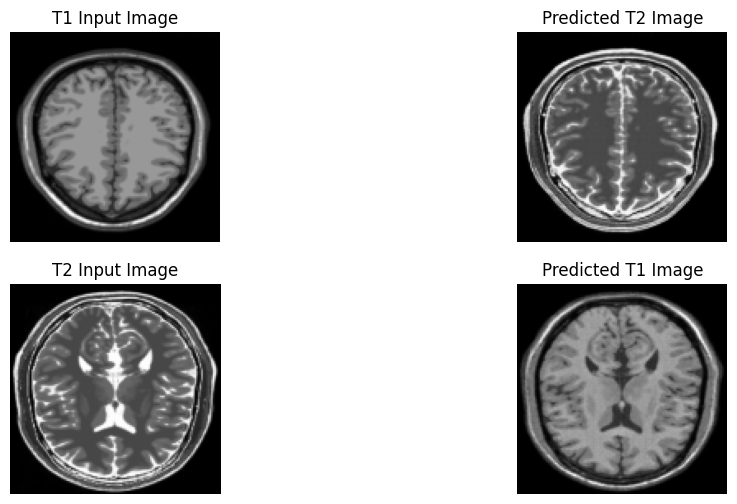

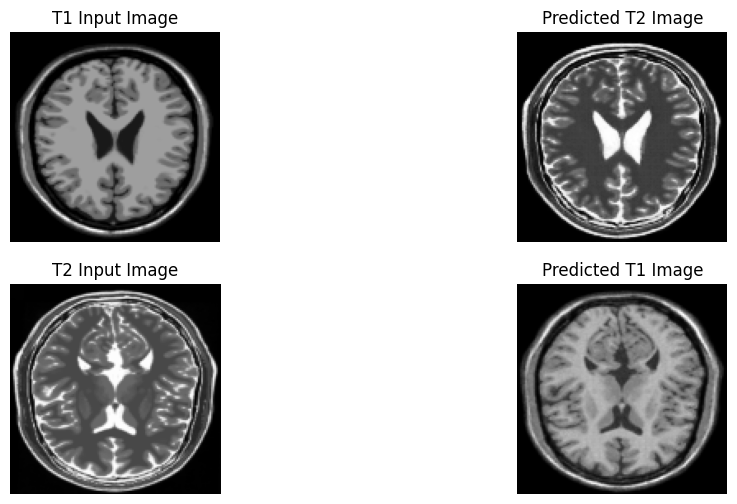

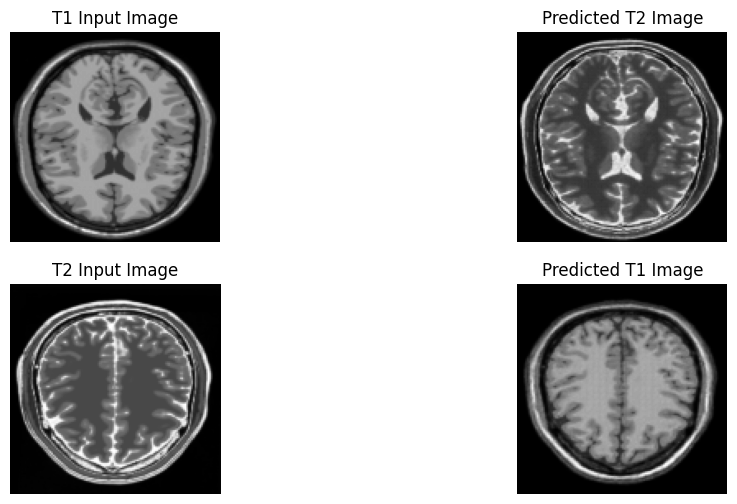

Time taken for epoch 100 is 21.28 sec



In [32]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf

EPOCHS = 100  # Update the number of epochs as needed

for epoch in range(EPOCHS):
    start = time.time()
    total_batches = len(t1_train)

    for batch_number, (t1, t2) in enumerate(tf.data.Dataset.zip((t1_train, t2_train))):
        batch_start = time.time()

        # Perform the training step
        train_step(t1, t2,
                   generator_g, generator_f,
                   discriminator_x, discriminator_y,
                   generator_g_optimizer, generator_f_optimizer,
                   discriminator_x_optimizer, discriminator_y_optimizer)

        # Calculate the time taken for the batch
        batch_time = time.time() - batch_start
        batches_left = total_batches - batch_number
        eta = batch_time * batches_left

        print(f'Epoch {epoch+1}/{EPOCHS} - Batch {batch_number+1}/{total_batches} - ETA: {eta:.2f}s', end='\r')

    # Clear the current output line and move to the next line
    print("\n")

    # Visualize the progress using the validation dataset for the last epoch only
    if epoch == EPOCHS - 1:
        for t1, t2 in tf.data.Dataset.zip((t1_val, t2_val)).take(3):
            fake_t2 = generator_g(t1, training=False)
            fake_t1 = generator_f(t2, training=False)
            plt.figure(figsize=(12, 6))

            display_list = [t1[0], fake_t2[0], t2[0], fake_t1[0]]
            title = ['T1 Input Image', 'Predicted T2 Image', 'T2 Input Image', 'Predicted T1 Image']

            for i in range(4):
                plt.subplot(2, 2, i+1)
                plt.title(title[i])
                plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
                plt.axis('off')
            plt.show()

    # Print the time taken for the epoch
    print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n')

# Continue with the rest of the code...

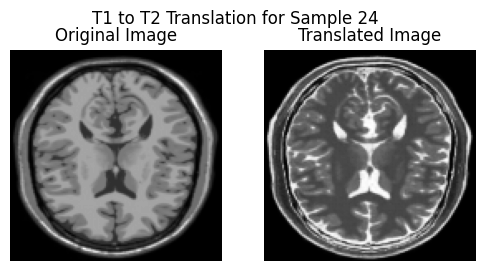

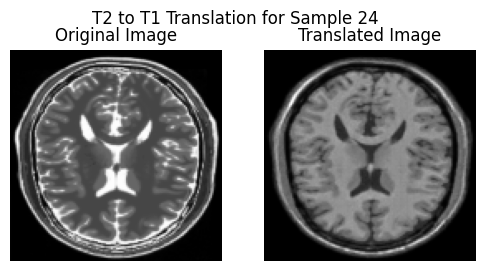

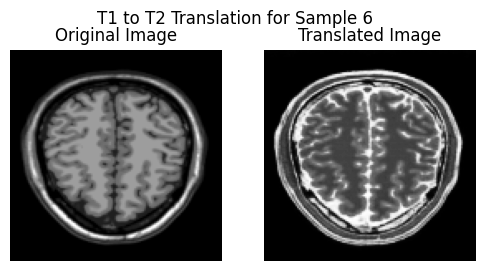

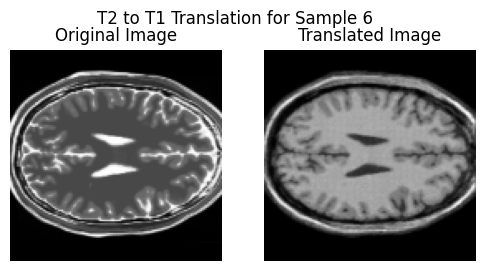

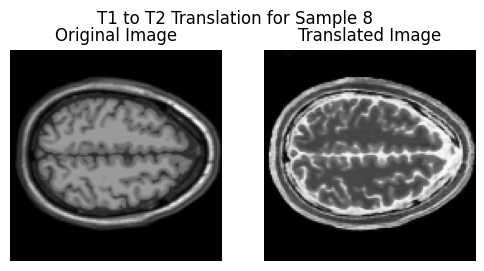

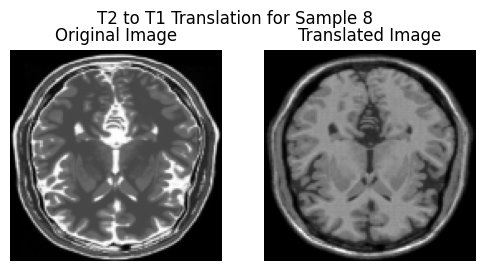

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Assuming that generator_g translates T1 to T2 and generator_f translates T2 to T1
# Assuming that t1_test and t2_test are your test datasets

# Function to translate images using a generator
def translate_images(generator, test_dataset):
    translated_images = []
    for img in test_dataset:
        # Remove the batch dimension added by `.batch(1)` since we're iterating over the dataset
        img = tf.expand_dims(img[0], 0)
        prediction = generator(img, training=False)
        translated_images.append(prediction[0].numpy())
    return translated_images

# Visualization function
def plot_translation(input_image, translated_image, title=''):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(input_image * 0.5 + 0.5, cmap='gray')  # Adjust if images are not normalized
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Translated Image')
    plt.imshow(translated_image * 0.5 + 0.5, cmap='gray')  # Adjust if images are not normalized
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Function to evaluate the model using a test dataset
def evaluate_model(generator_g, generator_f, test_dataset_t1, test_dataset_t2):
    # Translate T1 to T2 and T2 to T1 for three random samples
    for i in np.random.choice(len(test_dataset_t1), 3, replace=False):
        t1_img = next(iter(test_dataset_t1.take(1)))[0]  # Take one sample from t1
        t2_img = next(iter(test_dataset_t2.take(1)))[0]  # Take one sample from t2

        fake_t2_img = generator_g(t1_img, training=False)[0]
        fake_t1_img = generator_f(t2_img, training=False)[0]

        plot_translation(t1_img[0], fake_t2_img, title=f'T1 to T2 Translation for Sample {i+1}')
        plot_translation(t2_img[0], fake_t1_img, title=f'T2 to T1 Translation for Sample {i+1}')

# Prepare the test datasets
t1_test_batched = t1_test.batch(1)
t2_test_batched = t2_test.batch(1)

# Evaluate the model with the test datasets
evaluate_model(generator_g, generator_f, t1_test_batched, t2_test_batched)

In [45]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Function to calculate PSNR and SSIM for a batch of images
def calculate_metrics(generator, test_dataset, num_samples=3):
    psnr_values = []
    ssim_values = []

    for img in test_dataset.take(num_samples):
        # Reshape the image to remove the batch dimension
        # img is a batch of one image, so we take the first (and only) image in the batch
        img = img[0]  # img is now of shape (1, height, width, channels)
        ground_truth = img.numpy()[0]  # Remove the batch dimension

        # Generate the image
        generated_image = generator_f(img, training=False)
        generated_image = generated_image[0].numpy()  # Remove the batch dimension

        # Flatten the images if they have extra dimensions
        ground_truth = np.squeeze(ground_truth)
        generated_image = np.squeeze(generated_image)

        # Ensure the images are 2D arrays if they are grayscale
        if ground_truth.ndim == 3:
            ground_truth = ground_truth[..., 0]
        if generated_image.ndim == 3:
            generated_image = generated_image[..., 0]

        # Calculate PSNR and SSIM
        psnr = compare_psnr(ground_truth, generated_image, data_range=ground_truth.max() - ground_truth.min())
        ssim = compare_ssim(ground_truth, generated_image, data_range=ground_truth.max() - ground_truth.min())

        psnr_values.append(psnr)
        ssim_values.append(ssim)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f'Average PSNR over {num_samples} samples: {avg_psnr:.2f}')
    print(f'Average SSIM over {num_samples} samples: {avg_ssim:.2f}')

    return avg_psnr, avg_ssim

# Prepare the test datasets
t1_test_batched = t1_test.batch(1)
t2_test_batched = t2_test.batch(1)

# Calculate metrics for T2 to T1 translation
print("\nCalculating metrics for T2 to T1 translation...")
avg_psnr_t2_to_t1, avg_ssim_t2_to_t1 = calculate_metrics(generator_f, t2_test_batched, num_samples=100)


Calculating metrics for T2 to T1 translation...
Average PSNR over 100 samples: 10.91
Average SSIM over 100 samples: 0.18


In [43]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Function to calculate PSNR and SSIM for a batch of images
def calculate_metrics(generator, test_dataset, num_samples=3):
    psnr_values = []
    ssim_values = []

    for img in test_dataset.take(num_samples):
        # Reshape the image to remove the batch dimension
        # img is a batch of one image, so we take the first (and only) image in the batch
        img = img[0]  # img is now of shape (1, height, width, channels)
        ground_truth = img.numpy()[0]  # Remove the batch dimension

        # Generate the image
        generated_image = generator_f(img, training=False)
        generated_image = generated_image[0].numpy()  # Remove the batch dimension

        # Flatten the images if they have extra dimensions
        ground_truth = np.squeeze(ground_truth)
        generated_image = np.squeeze(generated_image)

        # Ensure the images are 2D arrays if they are grayscale
        if ground_truth.ndim == 3:
            ground_truth = ground_truth[..., 0]
        if generated_image.ndim == 3:
            generated_image = generated_image[..., 0]

        # Calculate PSNR and SSIM
        psnr = compare_psnr(ground_truth, generated_image, data_range=ground_truth.max() - ground_truth.min())
        ssim = compare_ssim(ground_truth, generated_image, data_range=ground_truth.max() - ground_truth.min())

        psnr_values.append(psnr)
        ssim_values.append(ssim)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f'Average PSNR over {num_samples} samples: {avg_psnr:.2f}')
    print(f'Average SSIM over {num_samples} samples: {avg_ssim:.2f}')

    return avg_psnr, avg_ssim

# Prepare the test datasets
t1_test_batched = t1_test.batch(1)
t2_test_batched = t2_test.batch(1)

# Calculate metrics for T1 to T2 translation
print("Calculating metrics for T1 to T2 translation...")
avg_psnr_t1_to_t2, avg_ssim_t1_to_t2 = calculate_metrics(generator_g, t1_test_batched, num_samples=100)

Calculating metrics for T1 to T2 translation...
Average PSNR over 100 samples: 15.03
Average SSIM over 100 samples: 0.32
